In [10]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks
from lmfit import Model

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18
wavelength, flux, err = load_binned_data('/Users/belugawhale/Documents/AUMic/30s/reduced/binned_data_a.npy')
wavelength2, flux2, err2 = load_binned_data('/Users/belugawhale/Documents/AUMic/30s/reduced2/binned_data_a.npy')

times = np.load('/Users/belugawhale/Documents/AUMic/30s/reduced/times.npy')
orbits = np.load('/Users/belugawhale/Documents/AUMic/30s/reduced/orbits.npy')
times2 = np.load('/Users/belugawhale/Documents/AUMic/30s/reduced2/times.npy')
orbits2 = np.load('/Users/belugawhale/Documents/AUMic/30s/reduced2/orbits.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)

np.append(flux, flux2, axis=0).shape

flare_mask = np.load('/Users/belugawhale/Documents/AUMic/flare_mask2.npy',
                     allow_pickle=True)

parula = np.load('/Users/belugawhale/parula_colors.npy')#[np.linspace(0,210,len(times),dtype=int)]
distance = (9.72*units.pc).to(units.cm)

letters = ['A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M']

which='paper'

if which=='presentation':
    highlight2='#FFC77B'
    highlight1='#E59B41'
    scolor='#577F81'
else:
    highlight2=parula[215]
    highlight1=parula[225]
    scolor=parula[100]
    
if COLOR=='k':
    path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/light-bkg'
else:
    path = '/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/dark-bkg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times-times[0], times2-times2[0]), 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/belugawhale/Documents/GitHub/cos_flares/')
fwc.measure_FUV130()
for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion=ion)

## Plot full light curve

In [3]:
wlc = np.trapz(fwc.flux, fwc.wavelength)
wlc_e = np.sqrt(np.nansum(fwc.flux_err**2, axis=1))/len(fwc.flux_err)

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_19790/2994583162.py:83: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join('/Users/belugawhale/Documents/AUMic/paper/', 'flux.pdf'),


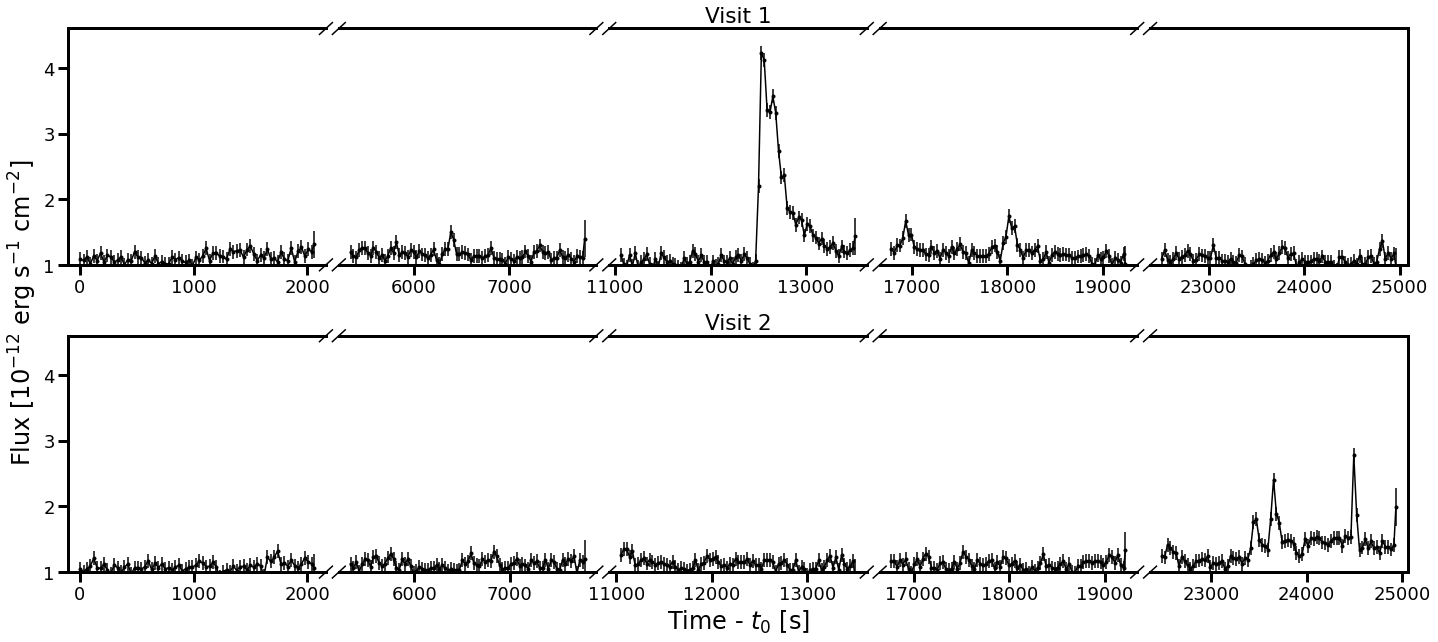

In [5]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(24,10))
ax = axes.reshape(-1)
#fig.set_facecolor('w')

d = .025
c=100

mcolor = COLOR

for j in range(0,10):
    q = fwc.orbit == j
    ax[j].errorbar(fwc.time[q].value, 
                   wlc[q],
                 yerr=wlc_e[q],
                 color=mcolor, marker='.')
    ax[j].set_ylim(1e-12,4.6e-12)
    
    if j in flare_mask[1]:
        inds = np.where(np.array(flare_mask[1])==j)[0]

        for n in inds:
            m = flare_mask[2][n] != 0
            #ax[j].axvspan(fwc.time[m][0].value, 
            #              fwc.time[m][-1].value, 0, 1,
            #              color=highlight2, alpha=0.5, lw=0)
            
            argmax = np.argmax(wlc[m])
            #ax[j].vlines(fwc.time[m][argmax].value,
            #             0, 1, color=highlight1, lw=4)
            #if letters[n]!='B':
            #    ax[j].text(s='Flare {}'.format(letters[n]),
            #               x=fwc.time[m][argmax].value,
            #               y=3.5e-12, rotation=270)
            #else:
            #    ax[j].text(s='Flare {}'.format(letters[n]),
            #               x=fwc.time[m][argmax].value+100,
            #               y=4.2e-12)
            c += 15
    
    if j!=0 and j !=4 and j!=5 and j !=9:
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        
    elif j == 0 or j == 5:
        ax[j].spines['right'].set_visible(False)
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
    else:
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        
    ax[j].set_ylim(1e-12,4.6e-12)
    if j == 2:
        ax[j].set_title('Visit 1')
    if j == 7:
        ax[j].set_title('Visit 2')
        ax[j].set_xlabel('Time - $t_0$ [s]', fontsize=24)

    if j == 5:
        ax[j].set_ylabel('Flux [$10^{-12}$ erg s$^{-1}$ cm$^{-2}$]', 
                           fontsize=24, y=1.1)
    if j == 0 or j == 5:
        ax[j].set_yticks(np.arange(1e-12,5e-12,1e-12))
        ax[j].set_yticklabels([int(e) for e in np.arange(1e-12,5e-12,1e-12)*1e12])
    ax[j].set_rasterized(True)

fig.set_facecolor('w')
plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.savefig(os.path.join('/Users/belugawhale/Documents/AUMic/paper/', 'flux.pdf'),
            rasterize=True, bbox_inches='tight', dpi=300, transparent=True)

### Calculating Flare Parameters

In [6]:
cut = [np.arange(1,6,1,dtype=int), 0, 0, np.arange(3,12,1,dtype=int),
       np.arange(1,5,1,dtype=int), np.arange(3,7,1,dtype=int),
       0, 0, 0, 0, np.arange(0,7,1,dtype=int), np.arange(1,5,1,dtype=int),
       np.arange(1,8,1,dtype=int)]

q = fwc.orbit == j
Fq = wlc[q]*units.erg/units.s/units.cm**2
Fq_err = wlc_e[q]*units.erg/units.s/units.cm**2
Fq = np.nanmedian(Fq)

for n in range(len(flare_mask[1])):

    m = flare_mask[2][n] != 0

    if type(cut[n])==np.ndarray:
        Ff = wlc[m][cut[n]] * units.erg/units.s/units.cm**2
        Ff_e = wlc_e[m][cut[n]] * units.erg/units.s/units.cm**2
        t = fwc.time[m][cut[n]]
    else:
        Ff = wlc[m] * units.erg/units.s/units.cm**2
        Ff_e = wlc_e[m] * units.erg/units.s/units.cm**2
        t = fwc.time[m]


    e = 4*np.pi*distance**2*np.trapz(Ff, t)
    err = 4*np.pi*distance**2*np.trapz(Ff_e, t)

    print(letters[n], '(', np.round(e/1e30, 2).value, '$\pm$', np.round(err/1e30, 2), ')')

A ( 1.78 $\pm$ 0.14 erg )
B ( 24.1 $\pm$ 1.4 erg )
C ( 4.17 $\pm$ 0.32 erg )
D ( 3.81 $\pm$ 0.29 erg )
E ( 1.19 $\pm$ 0.11 erg )
F ( 1.24 $\pm$ 0.11 erg )
G ( 2.42 $\pm$ 0.22 erg )
H ( 3.51 $\pm$ 0.32 erg )
I ( 2.01 $\pm$ 0.18 erg )
J ( 3.5 $\pm$ 0.25 erg )
K ( 3.64 $\pm$ 0.22 erg )
L ( 1.39 $\pm$ 0.11 erg )
M ( 3.53 $\pm$ 0.22 erg )


In [7]:
cut = [np.arange(1,6,1,dtype=int), 0, 0, np.arange(3,12,1,dtype=int),
       np.arange(1,5,1,dtype=int), np.arange(3,7,1,dtype=int),
       0, 0, 0, 0, np.arange(0,7,1,dtype=int), np.arange(1,5,1,dtype=int),
       np.arange(1,8,1,dtype=int)]

q = fwc.orbit == j
Fq = wlc[q]*units.erg/units.s/units.cm**2
Fq_err = np.nanstd(wlc_e[q]*units.erg/units.s/units.cm**2)
Fq = np.nanmedian(Fq)

for n in range(len(flare_mask[1])):

    m = flare_mask[2][n] != 0

    if type(cut[n])==np.ndarray:
        Ff = wlc[m][cut[n]] * units.erg/units.s/units.cm**2
        Ff_e = wlc_e[m][cut[n]] * units.erg/units.s/units.cm**2
        t = fwc.time[m][cut[n]]

    else:
        Ff = wlc[m] * units.erg/units.s/units.cm**2
        Ff_e = wlc_e[m] * units.erg/units.s/units.cm**2
        t = fwc.time[m]

    dur = np.trapz((Ff-Fq)/Fq, t)
    dur_e = np.trapz((Ff_e-Fq_err)/Fq, t)
    #print(np.round(t[np.argmax(Ff)],1))
    print(letters[n], '(', np.round(dur, 1).value, '$\pm$', 
          np.round(dur_e,1).value, ')')

A ( -6.0 $\pm$ 7.5 )
B ( 371.7 $\pm$ 72.9 )
C ( -3.2 $\pm$ 16.8 )
D ( 3.8 $\pm$ 15.0 )
E ( -13.9 $\pm$ 5.6 )
F ( -10.5 $\pm$ 5.6 )
G ( -25.4 $\pm$ 11.3 )
H ( -45.4 $\pm$ 16.9 )
I ( -21.5 $\pm$ 9.4 )
J ( 14.2 $\pm$ 13.2 )
K ( 53.0 $\pm$ 11.3 )
L ( -1.0 $\pm$ 5.6 )
M ( 45.9 $\pm$ 11.3 )


## Plot Si III and C III flares

In [8]:
letters = ['A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M']

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_19790/4147602916.py:121: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join('/Users/belugawhale/Documents/AUMic/paper/', 'ion_lightcurves.pdf'),


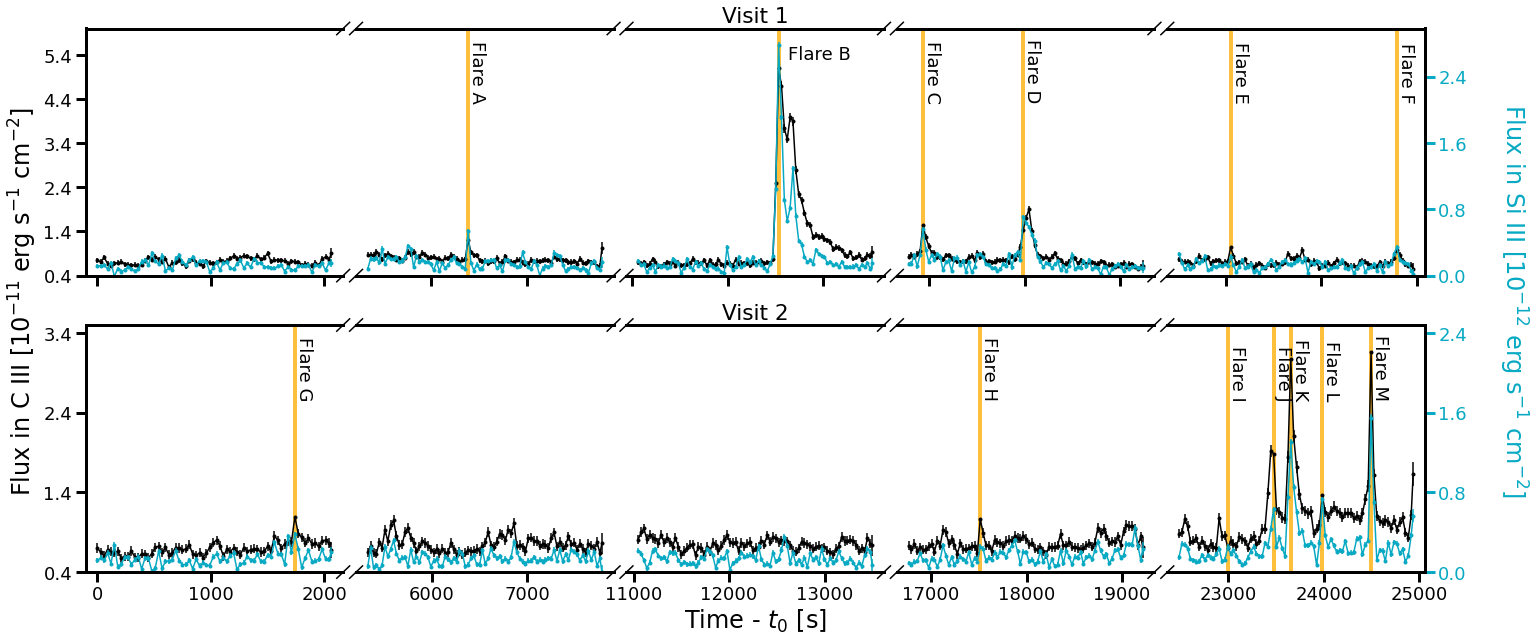

In [11]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(24,10))
ax = axes.reshape(-1)
#fig.set_facecolor('w')

d = .025
c=100

mcolor = COLOR

for j in range(0,10):
    q = fwc.orbit == j
    ax[j].errorbar(fwc.time[q].value, 
                 fwc.width_table['CIII'][q].value, 
                 yerr=fwc.error_table['CIII'][q].value,
                 color=mcolor, marker='.')
    
    ax2 = ax[j].twinx()
    
    ax2.errorbar(fwc.time[q].value, 
                 fwc.width_table['SiIII'][q].value, 
                 yerr=fwc.error_table['SiIII'][q].value/10,
                 color=scolor, marker='.')
    
    if j in flare_mask[1]:
        inds = np.where(np.array(flare_mask[1])==j)[0]

        for n in inds:
            m = flare_mask[2][n] != 0
            
            argmax = np.argmax(fwc.width_table['SiIII'][m])
            ax[j].vlines(fwc.time[m][argmax].value,
                         0, 1, color=highlight2, lw=4)
            if letters[n]!='B' and j < 5:
                ax[j].text(s='Flare {}'.format(letters[n]),
                           x=fwc.time[m][argmax].value,
                           y=4.4e-11, rotation=270)
            elif letters[n]!='B' and j >= 5:
                ax[j].text(s='Flare {}'.format(letters[n]),
                           x=fwc.time[m][argmax].value,
                           y=2.6e-11, rotation=270)
            else:
                ax[j].text(s='Flare {}'.format(letters[n]),
                           x=fwc.time[m][argmax].value+100,
                           y=5.3e-11)
            
            c += 15
            
            
    
    if j!=0 and j !=4 and j!=5 and j !=9:
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        
    elif j == 0 or j == 5:
        ax[j].spines['right'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
    else:
        ax[j].spines['left'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        

    if j == 2:
        ax[j].set_title('Visit 1')
    if j == 7:
        ax[j].set_title('Visit 2')
        ax[j].set_xlabel('Time - $t_0$ [s]', fontsize=24)

    if j < 5:
        ax[j].set_xticklabels([])

    if j == 0 or j == 5:
        yticks = np.arange(0.4e-11,6e-11,1e-11)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(np.round(yticks/1e-11, 2))
    if j < 5:
        ax[j].set_xticklabels([])
        ax[j].set_ylim(0.4e-11, 6e-11)
        ax2.set_ylim(0.2e-13, 3e-12)
    else:
        ax[j].set_ylim(0.4e-11, 3.5e-11)
        ax2.set_ylim(0.2e-13, 2.5e-12)
        
    if j == 9 or j == 4:
        yticks = np.arange(0.2e-13, 2.5e-12,8e-13)
        ax2.set_yticks(yticks)
        ax2.tick_params(axis='y', colors=scolor)
        ax2.set_yticklabels(np.round(yticks/1e-12, 1), color=scolor)
        
    if j == 5:
        ax[j].set_ylabel('Flux in C III [$10^{-11}$ erg s$^{-1}$ cm$^{-2}$]', 
                         fontsize=24, y=1.1)
    if j == 9:
        ax[j].set_ylabel('Flux in Si III [$10^{-12}$ erg s$^{-1}$ cm$^{-2}$]\n\n\n\n\n\n\n\n\n\n\n\n', 
                       fontsize=24, y=1.1, color=scolor, rotation=270)
    ax[j].set_rasterized(True)
        
fig.set_facecolor('w')
plt.subplots_adjust(wspace=0.05)
plt.savefig(os.path.join('/Users/belugawhale/Documents/AUMic/paper/', 'ion_lightcurves.pdf'),
            rasterize=True, bbox_inches='tight', dpi=300, transparent=True)

In [17]:
f = np.zeros(len(fwc.time))
e = np.zeros(len(fwc.time))
for i in range(len(fwc.time)):
    f[i] = np.trapz(fwc.flux[i]*fwc.flux_units, x=fwc.wavelength[i]*units.AA).value
    e[i] = np.trapz(fwc.flux_err[i]**2*fwc.flux_units,x=fwc.wavelength[i]*units.AA).value
    e[i] = np.sqrt(e[i]/len(fwc.flux_err[i]))

In [30]:
flare_params=np.zeros((len(amps),2))
flare_params[:,0]=tpeaks
flare_params[:,1]=amps
np.save('flare_peaks_amps.npy',flare_params)

In [94]:
qmask = np.nansum(flare_mask[2],axis=0) == 0

for i in range(len(flare_mask[2])):
    
    fmask = flare_mask[2][i] > 0
    energy, duration = fwc.measure_flare_params(qmask=qmask,
                                                fmask=fmask,
                                                d=distance,
                                                flux=f)
    Fq = np.nanmedian(f[qmask]/10**-13)*units.erg/units.s/units.cm**2
    Ff = (f[fmask]/10**-13)*units.erg/units.s/units.cm**2
    energy = np.trapz(Ff-Fq, x=fwc.time[fmask]) * 4 * np.pi * distance**2
    dur = np.trapz((Ff-Fq)/Fq, x=fwc.time[fmask])
    
    print(energy*10e-13, dur)

3.7596754287355347e+30 erg 29.352123365878384 s
9.459955426684652e+31 erg 738.5472070208607 s
7.723615907166813e+30 erg 60.29896230006933 s
1.0770878149658881e+31 erg 84.0892120078459 s
3.887545021205403e+29 erg 3.0350412745922686 s
1.4569704180589275e+30 erg 11.374698763739813 s
1.0300497229805887e+30 erg 8.04169059670226 s
1.1620953283917872e+30 erg 9.07258248442437 s
8.655609375569604e+30 erg 67.57511892031037 s
1.7585913138452138e+31 erg 137.29480156617484 s
5.629950108517327e+30 erg 43.95352557987131 s
1.821432055233202e+31 erg 142.2008346229801 s
